# Akciğer Radyolojik Görüntülerinden Evrişimsel Sinir Ağı ile Derin Öğrenme Modeli Geliştirme 

### Dr. Murat Gezer

Bu eğitimde kullanılan veri kümesi

https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

https://drive.google.com/file/d/1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou/view?usp=sharing


- M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676
- Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images


Bu eğitimde kullanılan 
- !pip install livelossplot
- !pip install gradient-centralization-tf
- !pip install scikit-plot
- !pip install --upgrade mlxtend

In [1]:
# License: BSD
# Author: Murat Gezer

from __future__ import print_function, division
 

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import PIL
import pathlib
import random

import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Input,Model
from tensorflow.keras import mixed_precision
from tensorflow.python.client import device_lib

from livelossplot import PlotLossesKeras

In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)
#print(device_lib.list_local_devices())
print(tf.__version__)
ROOT = os.getcwd()
#print(ROOT)

Compute dtype: float16
Variable dtype: float32
2.5.1


In [3]:
data_dir = os.path.join(ROOT,"data")
data_dir = pathlib.Path(data_dir)
data_image_count = len(list(data_dir.glob('*/*.png')))
print("Data Dizinindeki Görüntü:",data_image_count)

test_dir = os.path.join(ROOT,"test")
test_dir = pathlib.Path(test_dir)
test_image_count = len(list(test_dir.glob('*/*.png')))
print("Test dizinindeki görüntü:",test_image_count)


Data Dizinindeki Görüntü: 20965
Test dizinindeki görüntü: 200


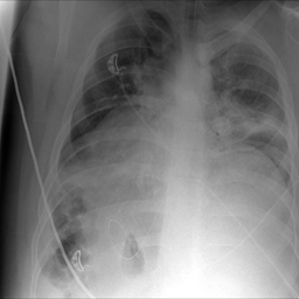

In [4]:
covid = list(data_dir.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

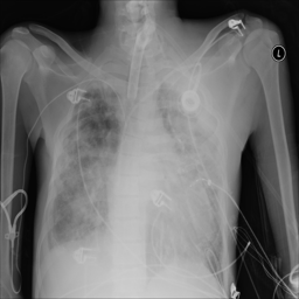

In [5]:
lung_opacity = list(data_dir.glob('LUNG_OPACITY/*'))
PIL.Image.open(str(lung_opacity[0]))

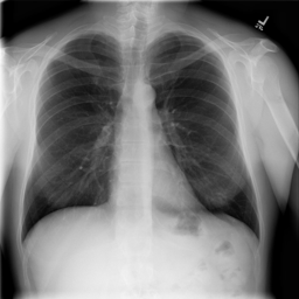

In [6]:
normal = list(data_dir.glob('NORMAL/*'))
PIL.Image.open(str(normal[0]))

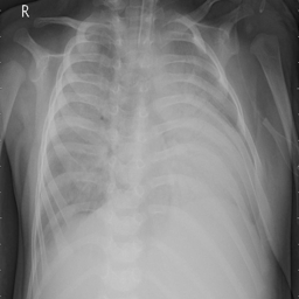

In [7]:
viral = list(data_dir.glob('VIRAL_PNEUMONIA/*'))
PIL.Image.open(str(viral[0]))

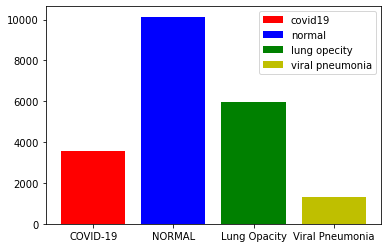

In [8]:
#Görselleştirme
fig, ax = plt.subplots()
ax.bar("COVID-19",len(covid),color="r",label="covid19")
ax.bar("NORMAL",len(normal),color="b",label="normal")
ax.bar("Lung Opacity",len(lung_opacity),color="g",label="lung opecity")
ax.bar("Viral Pneumonia",len(viral),color="y",label="viral pneumonia")
ax.legend()

In [9]:
batch_size = 32
img_height = 60
img_width = 60
num_classes = 4
epochs = 20


In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    interpolation="bilinear",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 20965 files belonging to 4 classes.
Using 16772 files for training.


In [11]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'LUNG_OPACITY', 'NORMAL', 'VIRAL_PNEUMONIA']


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    interpolation="bilinear",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 20965 files belonging to 4 classes.
Using 4193 files for validation.


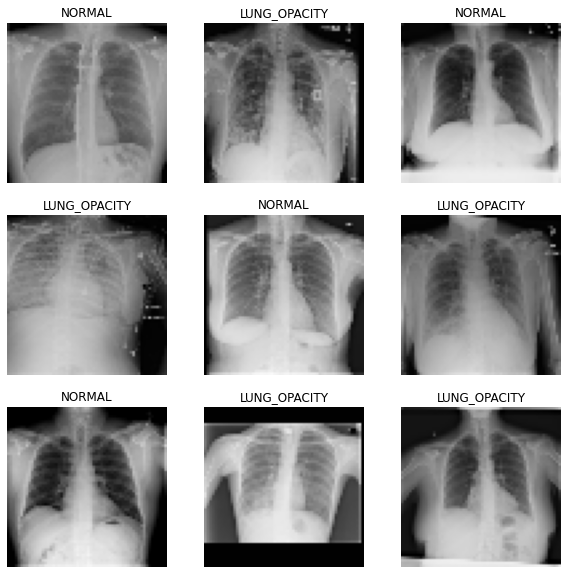

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomRotation(0.1, 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
        layers.experimental.preprocessing.RandomZoom(0.01)
    ]
)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #32
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #32

In [16]:
image_size=(img_height, img_width,3)
def baseModel(num_classes=num_classes,filtre=8,kernel=3):
    inputs = Input((img_height, img_width,3))
    # Image augmentation block
    #x = data_augmentation(inputs)

    x = layers.Conv2D(filters=filtre, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.AveragePooling2D()(x)
    x = layers.Conv2D(filters=filtre*2, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.AveragePooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu',kernel_initializer='he_uniform') (x)
    x = layers.Dense(84, activation='relu',kernel_initializer='he_uniform') (x)
    outputs = layers.Dense(4,activation="softmax")(x)
    
    model = Model(inputs, outputs)
    model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
    
    return model





In [17]:
hekim1=baseModel()
#keras.utils.plot_model(hekim1, show_shapes=True)

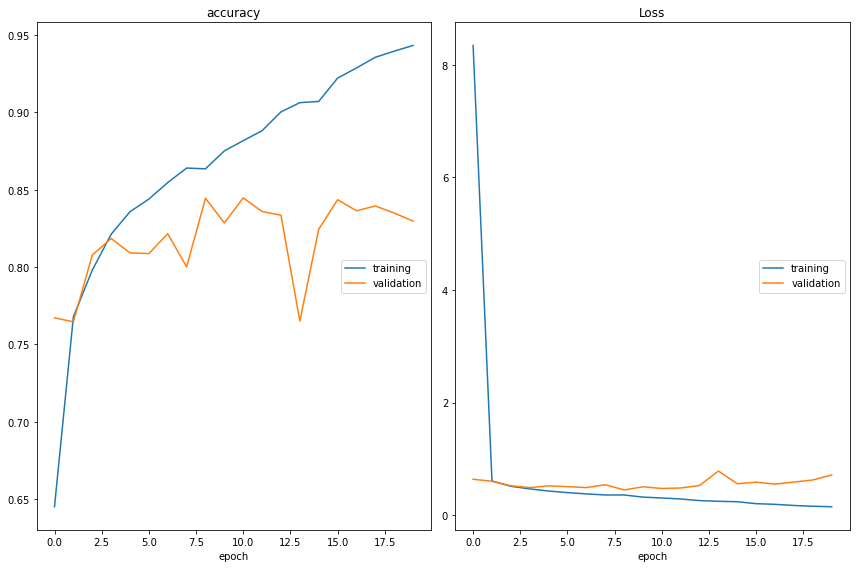

accuracy
	training         	 (min:    0.645, max:    0.943, cur:    0.943)
	validation       	 (min:    0.765, max:    0.845, cur:    0.830)
Loss
	training         	 (min:    0.149, max:    8.346, cur:    0.149)
	validation       	 (min:    0.447, max:    0.783, cur:    0.714)


In [18]:



callbacks = [
    PlotLossesKeras()
]


history = hekim1.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)

In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    interpolation="bilinear",
    image_size=(img_height, img_width),
    batch_size=batch_size)
hekim1.evaluate(test_ds)


Found 200 files belonging to 4 classes.
7/7 [==============================] - 1s 5ms/step - loss: 0.6520 - accuracy: 0.8300


[0.6520116925239563, 0.8299999833106995]

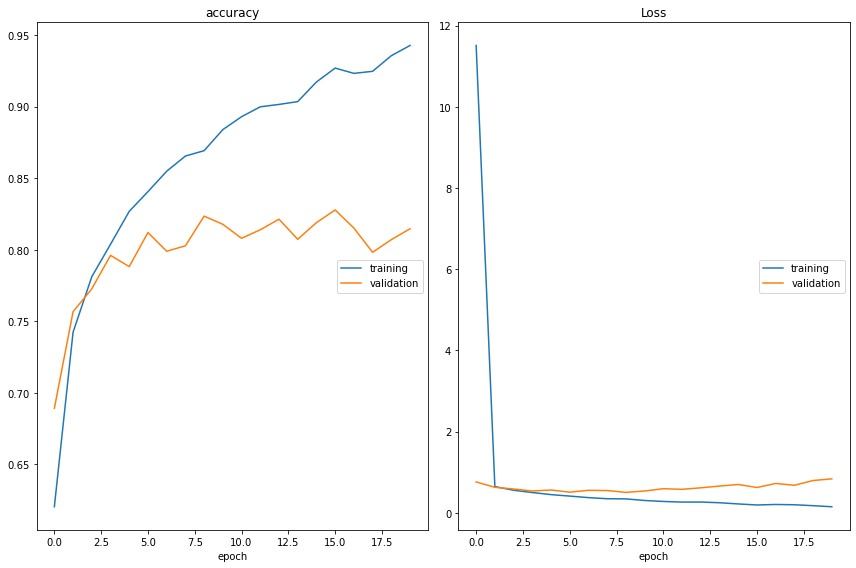

accuracy
	training         	 (min:    0.620, max:    0.943, cur:    0.943)
	validation       	 (min:    0.689, max:    0.828, cur:    0.815)
Loss
	training         	 (min:    0.150, max:   11.512, cur:    0.150)
	validation       	 (min:    0.503, max:    0.837, cur:    0.837)
7/7 [==============================] - 0s 4ms/step - loss: 0.7895 - accuracy: 0.7850


[0.7894921898841858, 0.7850000262260437]

In [20]:
callbacks = [
    PlotLossesKeras()
]
hekim2=baseModel(num_classes=num_classes,filtre=8,kernel=5)
hekim2.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)
hekim2.evaluate(test_ds)

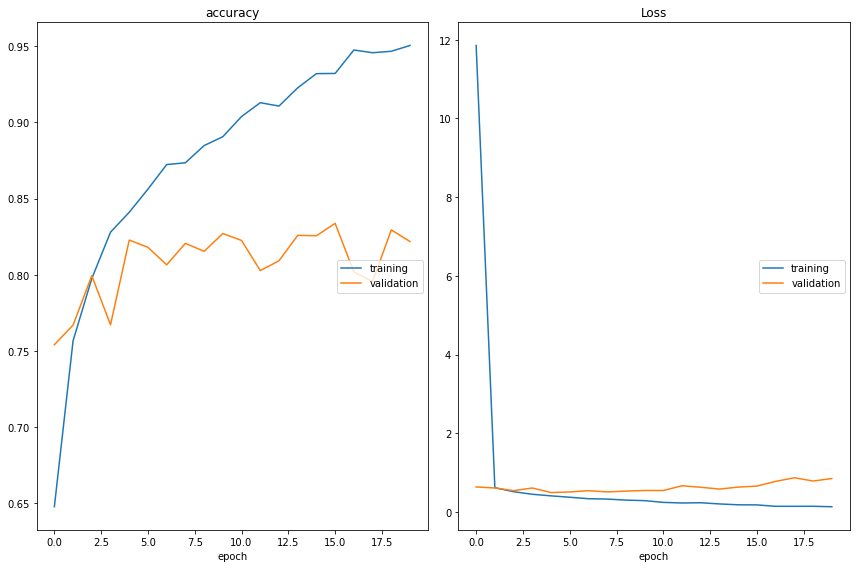

accuracy
	training         	 (min:    0.648, max:    0.951, cur:    0.951)
	validation       	 (min:    0.754, max:    0.834, cur:    0.822)
Loss
	training         	 (min:    0.132, max:   11.855, cur:    0.132)
	validation       	 (min:    0.492, max:    0.869, cur:    0.849)
7/7 [==============================] - 0s 4ms/step - loss: 0.8719 - accuracy: 0.7750


[0.8718945384025574, 0.7749999761581421]

In [21]:
callbacks = [
    PlotLossesKeras()
]
hekim3=baseModel(num_classes=num_classes,filtre=6,kernel=5)
hekim3.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)
hekim3.evaluate(test_ds)

In [22]:
# hekim heyet raporu alalım
inputs = Input((img_height, img_width,3))

# hekim heyet raporunda her bir hekin oyu var 
o1 = hekim1(inputs)
o2 = hekim2(inputs)
o3 = hekim3(inputs)

# her birinin oyunu topluyoruz ve aktivasyon fonksiyonuna gönderiyoruz
outputs = layers.Add()([o1, o2, o3])
outputs = layers.Activation('softmax')(outputs)

ensemble = Model(inputs, outputs)
ensemble.summary()
ensemble.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
ensemble.evaluate(test_ds)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60, 60, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 4)            444016      input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 4)            446448      input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 4)            336892      input_4[0][0]                    
____________________________________________________________________________________________

[0.4927343726158142, 0.8550000190734863]

This image most likely belongs to COVID with a 37.96 percent confidence.


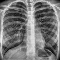

In [23]:
test_dir = "./test"
test_dir = pathlib.Path(test_dir)
test=pathlib.Path(test_dir,"COVID","COVID-1790.png")



img = keras.preprocessing.image.load_img(test, target_size=(img_height, img_width))

img_array1 = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch

predictions = hekim1.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img

This image most likely belongs to COVID with a 40.82 percent confidence.


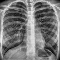

In [24]:
predictions = hekim2.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img

This image most likely belongs to COVID with a 47.51 percent confidence.


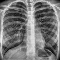

In [25]:
predictions = hekim3.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img

This image most likely belongs to COVID with a 40.09 percent confidence.


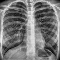

In [26]:
predictions = ensemble.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img